In [1]:
import pandas as pd
import numpy as np

import gensim
import gensim.corpora as corpora
#from gensim.models import CoherenceModel <-- lda model evaluation
from gensim import models
from gensim.models import Phrases

import spacy

from pprint import pprint

In [2]:
data = pd.read_csv('articles_bbc_2018_01_30.csv')

In [3]:
data = data.dropna().reset_index(drop=True)

In [4]:
data.shape

(308, 2)

In [5]:
nlp = spacy.load("en_core_web_md")

In [6]:
# Workaround to fix spaCy's stopwords not being recognized
for word in nlp.Defaults.stop_words:
    w = nlp.vocab[word]
    w.is_stop = True

In [7]:
# Adding custom stop words
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'image', 'getty', 'de', 'en', 'caption', 'also', 'copyright', 'something']
stopwords_custom = stopwords_verbs + stopwords_other

for word in stopwords_custom:
    w = nlp.vocab[word]
    w.is_stop = True

# Cleaning

#### Keeping English articles

In [8]:
from langdetect import detect

In [9]:
# Ri-crea la colonna 'lang' usando il detector per capire che lingua è
# (risolvendo possibili entry sbagliate)
data['lang'] = pd.Series([detect(article) for article in data.articles])

In [10]:
data.lang.value_counts()

en    257
fa      9
fr      7
id      5
uk      4
hi      4
ru      4
vi      4
ar      4
sw      3
tr      2
es      2
pt      2
de      1
Name: lang, dtype: int64

In [11]:
# Mi tengo solo quelli inglesi
data = data.loc[data.lang=='en']
data.shape

(257, 2)

In [ ]:
# Saving english articles to JSON
'''
articles_dict = {}
articles_list = []
i = 0
for doc in data['articles']:
    a = {}
    a['id'] = i
    a['text'] = doc
    i += 1
    articles_list.append(a)
articles_dict['articles'] = articles_list
import json
file = '/Users/lorenzocorti/Desktop/Poli/Assegno/Trigger/news-analytics/test_modules/topic_extraction/data.json'
with open(file, 'w') as fp:
    json.dump(articles_dict, fp)
'''

#### Tokenization (already done when going string -> doc objects)

Convert articles from string to spaCy's doc objects

In [13]:
data['articles'] = data['articles'].map(nlp)
'''
spaCy already does this:
- tokenize
- lemmatize
- POS tagging
- dependency parsing
- recognize stop words
- pair together noun chunks (e.g. 'the senate')
... others
'''

"\nspaCy already does this:\n- tokenize\n- lemmatize\n- POS tagging\n- dependency parsing\n- recognize stop words\n- pair together noun chunks (e.g. 'the senate')\n... others\n"

In [14]:
data.head()

,articles,lang
0,"(Image, copyright, PA, /, EPA, Image, caption,...",en
1,"(Husband, admits, killing, French, jogger, \r\...",en
2,"(Media, playback, is, unsupported, on, your, d...",en
3,"(Manchester, City, 's, Leroy, Sane, is, ruled,...",en
4,"(Image, copyright, AFP, Image, caption, Sebast...",en


Sentences

In [15]:
def sentencizer(doc):
    #return [sent.text for sent in doc.sents]    # returns sentences in raw text
    return [sent for sent in doc.sents]         # returns spaCy's sentence objects

data['sentences'] = data['articles'].map(sentencizer)

In [16]:
data.head()

,articles,lang,sentences
0,"(Image, copyright, PA, /, EPA, Image, caption,...",en,"[(Image, copyright, PA, /, EPA, Image, caption..."
1,"(Husband, admits, killing, French, jogger, \r\...",en,"[(Husband, admits, killing, French, jogger, \r..."
2,"(Media, playback, is, unsupported, on, your, d...",en,"[(Media, playback, is, unsupported, on, your, ..."
3,"(Manchester, City, 's, Leroy, Sane, is, ruled,...",en,"[(Manchester, City, 's, Leroy, Sane, is, ruled..."
4,"(Image, copyright, AFP, Image, caption, Sebast...",en,"[(Image, copyright, AFP, Image, caption, Sebas..."


In [17]:
pprint(data['sentences'][5]) # 8 sentences

[The middle of nowhere

,
 Five miles from the South Dakota border in the remote northern reaches of the US state of Nebraska, a long dirt road cuts through rolling prairie grasslands and golden wheat fields towards downtown Monowi, a place you can see in its entirety by climbing any of its hay bales.

,
 An abandoned church, whose empty pews are now filled with tractor tyres, stands opposite the decaying skeleton of a grain elevator.,
 Weeds and brome grass twist around the rotting remnants of homes that are collapsing in on themselves.,
 And inside a white, squat building with paint peeling off its frame, 84-year-old Elsie Eiler is flipping pork fritters and cracking open beer bottles for a pair of regulars under a sign that reads: “,
 Welcome To The World Famous Monowi Tavern.,
 Coldest Beer In Town!”

,
 When Eiler’s husband, Rudy, passed away in 2004, he didn’t just leave her to run the tavern, but the whole town.,
 Today, according to the US Census, Monowi is the only incorporate

#### Lemmatizing + stop word removal

In [18]:
# lemmatize each token if it's not a stop word and its length > 1
def lemmatizer(doc):
    lemmas = []
    for sent in doc:
        lemmas.append([token.lemma_ for token in sent 
            if (not nlp.vocab[token.lower_].is_stop and not token.is_punct and len(token.text)>1)])
    return lemmas

data['tokens_sentences_lemmatized'] = data['sentences'].map(lemmatizer)

In [19]:
data.head()

,articles,lang,sentences,tokens_sentences_lemmatized
0,"(Image, copyright, PA, /, EPA, Image, caption,...",en,"[(Image, copyright, PA, /, EPA, Image, caption...","[[PA, EPA, oligarch, Roman, Abramovich, PM, Dm..."
1,"(Husband, admits, killing, French, jogger, \r\...",en,"[(Husband, admits, killing, French, jogger, \r...","[[husband, admit, kill, french, jogger, \r\n\r..."
2,"(Media, playback, is, unsupported, on, your, d...",en,"[(Media, playback, is, unsupported, on, your, ...","[[medium, playback, unsupported, device, media..."
3,"(Manchester, City, 's, Leroy, Sane, is, ruled,...",en,"[(Manchester, City, 's, Leroy, Sane, is, ruled...","[[Manchester, City, Leroy, Sane, rule, seven, ..."
4,"(Image, copyright, AFP, Image, caption, Sebast...",en,"[(Image, copyright, AFP, Image, caption, Sebas...","[[AFP, Sebastien, Bras, take, famed, restauran..."


In [20]:
from itertools import chain
def flatten_tokens(doc):
    return list(chain.from_iterable(doc))
#data['tokens'] = data['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
data['tokens'] = data['tokens_sentences_lemmatized'].map(flatten_tokens)
data.head()

,articles,lang,sentences,tokens_sentences_lemmatized,tokens
0,"(Image, copyright, PA, /, EPA, Image, caption,...",en,"[(Image, copyright, PA, /, EPA, Image, caption...","[[PA, EPA, oligarch, Roman, Abramovich, PM, Dm...","[PA, EPA, oligarch, Roman, Abramovich, PM, Dmi..."
1,"(Husband, admits, killing, French, jogger, \r\...",en,"[(Husband, admits, killing, French, jogger, \r...","[[husband, admit, kill, french, jogger, \r\n\r...","[husband, admit, kill, french, jogger, \r\n\r\..."
2,"(Media, playback, is, unsupported, on, your, d...",en,"[(Media, playback, is, unsupported, on, your, ...","[[medium, playback, unsupported, device, media...","[medium, playback, unsupported, device, media,..."
3,"(Manchester, City, 's, Leroy, Sane, is, ruled,...",en,"[(Manchester, City, 's, Leroy, Sane, is, ruled...","[[Manchester, City, Leroy, Sane, rule, seven, ...","[Manchester, City, Leroy, Sane, rule, seven, w..."
4,"(Image, copyright, AFP, Image, caption, Sebast...",en,"[(Image, copyright, AFP, Image, caption, Sebas...","[[AFP, Sebastien, Bras, take, famed, restauran...","[AFP, Sebastien, Bras, take, famed, restaurant..."


# LDA

## Data preparation

#### Prepare bi-grams and tri-grams

In [21]:
tokens = data['tokens'].tolist()
bigram_model = Phrases(tokens) # combina le parole che compaiono comunemente insieme
trigram_model = Phrases(bigram_model[tokens], min_count=1) #stessa cosa ma a livello di (eventuali) tri-gram
tokens = list(trigram_model[bigram_model[tokens]])

In [22]:
for i in range(len(tokens[:20])):
    print(len(tokens[i]))

339
12
295
14
333
105
60
9
391
193
15
340
7
11
46
86
665
516
411
290


#### Prepare objects for LDA gensim implementation

In [23]:
dictionary_LDA = corpora.Dictionary(tokens) # creo un dizionario con le mie parole (ripulite, abbinate, etc...)
dictionary_LDA.filter_extremes(no_below=3) # rimuovo i token che compaiono in meno di 3 documenti (≥ 3 li tengo)

# traformo ogni documento in una bag of words
# ogni documento lista di (numero parola, numero documento)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

## Running LDA

In [24]:
np.random.seed(123456)
num_topics = 20 # cerco 20 topic
'''
LDA model estimation
- allenato su corpus
- id2word: dizionario con mapping ID -> parola
- passes: training loops
- alpha: probabilità che un topic ci sia in un documento (priori)
- eta: probabilità che una parola sia legata ad un topic
'''
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 1.96 s, sys: 38.3 ms, total: 2 s
Wall time: 2.65 s


## Quick exploration of LDA results

#### Looking at topics

In [25]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.014*"say" + 0.012*"find" + 0.012*"market" + 0.012*"company" + 0.011*"thing" + 0.011*"firm" + 0.010*"british" + 0.010*"Americans" + 0.009*"american" + 0.008*"UK" + 0.007*"listen" + 0.007*"buy" + 0.007*"digital" + 0.007*"live" + 0.007*"New_York" + 0.006*"big" + 0.006*"fatal" + 0.006*"gun" + 0.006*"supermarket" + 0.005*"new"

1: 0.017*"UK" + 0.016*"Brexit" + 0.012*"year" + 0.011*"transition" + 0.010*"say" + 0.010*"EU" + 0.010*"tell" + 0.009*"month" + 0.008*"rule" + 0.008*"come" + 0.007*"pick" + 0.007*"deal" + 0.007*"government" + 0.006*"final" + 0.006*"well" + 0.006*"go" + 0.006*"happen" + 0.006*"husband" + 0.006*"day" + 0.005*"bird"

2: 0.037*"say" + 0.008*"people" + 0.008*"find" + 0.008*"think" + 0.006*"year" + 0.006*"work" + 0.006*"go" + 0.005*"case" + 0.004*"get" + 0.004*"old" + 0.004*"system" + 0.004*"time" + 0.004*"take" + 0.004*"life" + 0.003*"restaurant" + 0.003*"world" + 0.003*"review" + 0.003*"thing" + 0.003*"away" + 0.003*"lot"

3: 0.014*"say" + 0.012*"write" + 0.008*"Afri

#### Allocating topics to documents

In [26]:
#print(data.articles.loc[0][:500])

In [27]:
lda_model[corpus[11]] # ad ogni documento sono stati associati i topic (con le rispettive probabilità)

[(3, 0.9990602)]

#### Predicting topics on unseen documents

In [28]:
document = '''Eric Tucker, a 35-year-old co-founder of a marketing company in Austin, Tex., had just about 40 Twitter followers. But his recent tweet about paid protesters being bused to demonstrations against President-elect Donald J. Trump fueled a nationwide conspiracy theory — one that Mr. Trump joined in promoting. 

Mr. Tucker's post was shared at least 16,000 times on Twitter and more than 350,000 times on Facebook. The problem is that Mr. Tucker got it wrong. There were no such buses packed with paid protesters.

But that didn't matter.

While some fake news is produced purposefully by teenagers in the Balkans or entrepreneurs in the United States seeking to make money from advertising, false information can also arise from misinformed social media posts by regular people that are seized on and spread through a hyperpartisan blogosphere.

Here, The New York Times deconstructs how Mr. Tucker’s now-deleted declaration on Twitter the night after the election turned into a fake-news phenomenon. It is an example of how, in an ever-connected world where speed often takes precedence over truth, an observation by a private citizen can quickly become a talking point, even as it is being proved false.'''

doc = nlp(document)
sentences = sentencizer(doc)
tokens = lemmatizer(sentences)
tokens = flatten_tokens(tokens)

# Recupero i topics, formattati come stringhe, 20 parole max per ognuno
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20)
# creo un dataframe con i topic abbinati al documento qui sopra
# per ogni topic recupero il numero, la sua probabilità e le parole associate (topics[el[0]][1])
pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) for el in lda_model[dictionary_LDA.doc2bow(tokens)]], columns=['topic #', 'weight', 'words in topic'])

,topic #,weight,words in topic
0,2,0.25,"0.037*""say"" + 0.008*""people"" + 0.008*""find"" + ..."
1,3,0.16,"0.014*""say"" + 0.012*""write"" + 0.008*""Africa"" +..."
2,6,0.16,"0.033*""say"" + 0.009*""people"" + 0.009*""question..."
3,14,0.16,"0.013*""say"" + 0.008*""time"" + 0.005*""water"" + 0..."
4,16,0.13,"0.027*""say"" + 0.009*""design"" + 0.009*""people"" ..."
5,18,0.14,"0.015*""say"" + 0.009*""work"" + 0.009*""Amazon"" + ..."


Update LDA model with new document

In [ ]:
def process_doc(doc):
    d = nlp(document)
    sentences = sentencizer(d)
    tokens = lemmatizer(sentences)
    tokens = flatten_tokens(tokens)

def update_lda_model(model, doc):



In [44]:
lda_model.update([dictionary_LDA.doc2bow(tokens)])

## Advanced exploration of LDA results

#### Allocation of topics in all documents

In [29]:
# abbino ogni topic ad un documento
topics = [lda_model[corpus[i]] for i in range(len(data))]

In [30]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0385366,NaN,NaN,NaN,NaN,NaN,0.0913012,NaN,NaN,0.869287,NaN


In [31]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [32]:
document_topic.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.998306,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.976828,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.998843,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.973609,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.999006,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [33]:
# Which document are about topic 14
document_topic.sort_values(14, ascending=False)[14].head(20)

232    0.999567
136    0.999525
107    0.999358
101    0.993909
216    0.993013
240    0.991822
71     0.976828
155    0.973607
210    0.963452
185    0.960702
39     0.879144
233    0.753514
59     0.751108
248    0.669300
60     0.536909
241    0.464690
130    0.360085
16     0.343376
173    0.311970
243    0.271294
Name: 14, dtype: float64

In [34]:
#print(data.articles.loc[91][:1000])

#### Looking at the distribution of topics in all documents

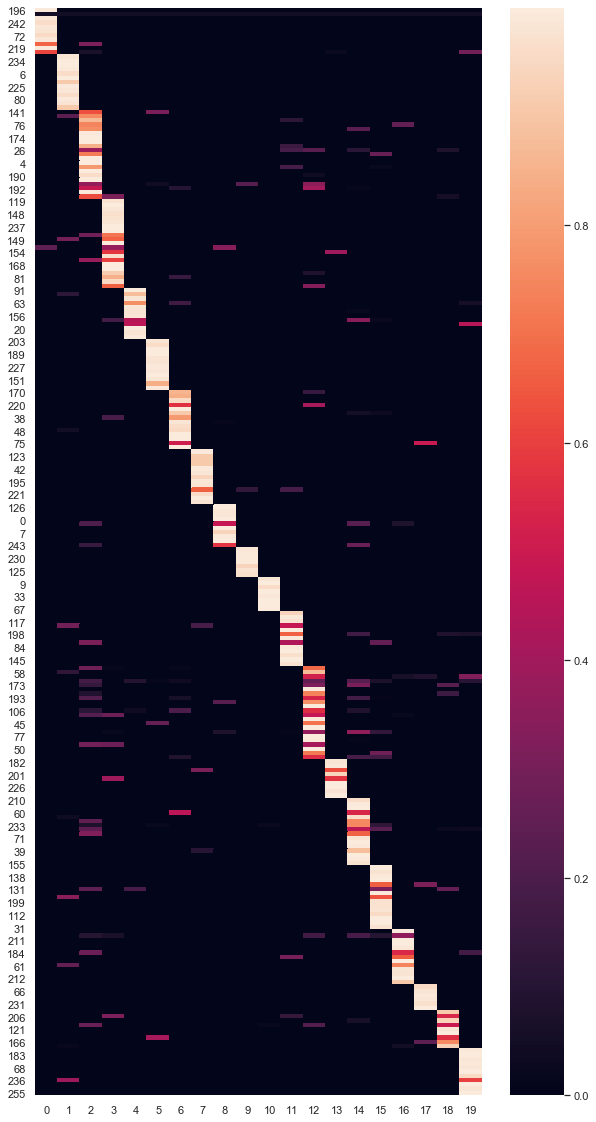

In [35]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

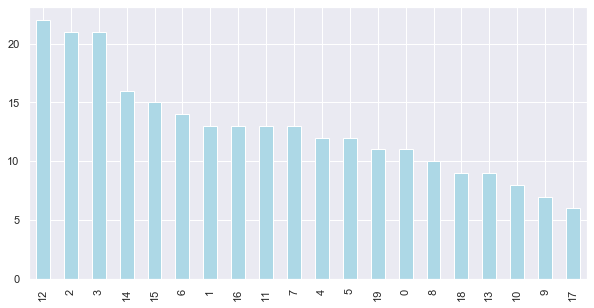

In [36]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

Saving model to file

In [48]:
import pickle

pprint("Saving...")
def save_lda_model():
    file_name = "./lda_model/lda_checkpoint"
    chekpointfile = open(file_name, "wb")
    pickle.dump(lda_model, chekpointfile)
    chekpointfile.close()
    return

pprint("Model saved!")
pprint("== Test model loading ==")
pprint("Loading...")

def load_lda_model():
    file_name = "./lda_model/lda_checkpoint"
    checkpointfile = open(file_name,"rb")
    loaded_lda = pickle.load(checkpointfile)
    checkpointfile.close()
    return loaded_lda

new_lda = load_lda_model()
pprint("Model loaded!")


'Saving...'
'Model saved!'
'== Test model loading =='
'Loading...'
'Model loaded!'


#### Visualizing topics

In [48]:
# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/Users/lorenzocorti/.vscode/extensions/ms-python.python-2020.5.80290/pythonFiles/lib/python/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


KeyboardInterrupt: 

Export per Toc

In [126]:
topics_doc_dict = {}
for i in range(len(data)):
    #print('---- Documento ',i,' ----')
    current_doc_topics = topics[i]
    for j in range(len(current_doc_topics)):
        topic = current_doc_topics[j]
        if len(topic) == 1:
            topic = topic[0]
        #print(topic)
        topic = (topic[0], str(topic[1]))
        current_doc_topics[j] = topic
    
    topics_doc_dict[str(i)] = {'topic': current_doc_topics, 'words': lda_model.show_topics(formatted = True, num_topics = num_topics, num_words = 20)[topics[i][0][0]]}
    
#topics_doc_dict['2']['topic'][0]

In [128]:
import json
with open('doc_topic.json', 'w') as fp:
    json.dump(topics_doc_dict, fp)